In [1]:
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 500)

In [2]:
book_cutoffs = "../booklist.csv"
cutoffs = pd.read_csv(book_cutoffs,index_col='asin')

In [3]:
cutoffs.head()

,book_num_reviews,std_HVAR,top_quartile_HVAR
asin,,,
000100039X,86,2.930287,0.842702
0001055178,12,0.332911,0.465856
0001712772,4,0.635544,1.148897
0001714538,4,0.099335,0.171246
0002005395,7,0.287376,0.782166


In [4]:
cutoffs.describe()

,book_num_reviews,std_HVAR,top_quartile_HVAR
count,197298.000000,1.972980e+05,197298.000000
mean,13.480745,1.777825e+00,1.685347
std,28.154276,3.280041e+00,2.001595
min,4.000000,1.199178e-16,0.000000
25%,5.000000,4.637533e-01,0.705740
50%,7.000000,9.378294e-01,1.154282
75%,13.000000,1.950738e+00,1.987549
max,2472.000000,3.786433e+02,128.641696


In [5]:
dataset = "../dev.json"
df = pd.read_json(dataset,lines=True)

In [6]:
# Peel out count of helpful votes into its own column
df['helpful_votes'] = df.apply(lambda x: x.helpful[0],axis=1)
# To avoid confusion later, drop the 'helpful' column at this point
df.drop('helpful', axis = 1, inplace=True)
# Convert reviewTime to datetime type info we can work with
df.reviewTime = pd.to_datetime(df.reviewTime,infer_datetime_format=True)

In [7]:
print("Our dataset initially contains {} reviews".format(df.shape[0]))

Our dataset initially contains 476793 reviews


In [8]:
# Our dataset snapshot has as its maximum review date 2014-07-23
snapshotted_string = "20140723"
snapshotted = datetime.datetime.strptime(snapshotted_string, '%Y%m%d')

# We will DROP reviews less than one year old
# They may not have accumulated enough evidence to support being helpful or not
ourcutoff = snapshotted - datetime.timedelta(days=365)
df = df[df.reviewTime < ourcutoff]
print("After removing reviews less than one year old, our dataset contains {} reviews".format(df.shape[0]))

After removing reviews less than one year old, our dataset contains 361268 reviews


In [9]:
# Here we store the age of each review in days
df['review_age_days'] = df.apply(lambda x: (snapshotted - x.reviewTime).days,axis = 1)

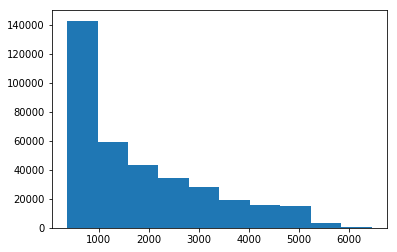

In [10]:
days_old_hist = plt.hist(df['review_age_days'])

In [11]:
# We create the annual HVAR score
df['annual_HVAR'] = df.apply(lambda x: 365*x.helpful_votes/x.review_age_days, axis = 1)

In [12]:
df.describe()

,overall,unixReviewTime,helpful_votes,review_age_days,annual_HVAR
count,361268.000000,3.612680e+05,361268.000000,361268.000000,361268.000000
mean,4.079600,1.251428e+09,6.731725,1789.878157,1.613838
std,1.203999,1.166730e+08,24.970046,1350.382014,6.785194
min,1.000000,8.492256e+08,0.000000,366.000000,0.000000
25%,3.000000,1.178582e+09,1.000000,651.000000,0.291417
50%,5.000000,1.292112e+09,2.000000,1319.000000,0.662432
75%,5.000000,1.349827e+09,5.000000,2633.000000,1.384674
max,5.000000,1.374451e+09,3652.000000,6445.000000,990.843672


In [13]:
# Now we join the dev dataset and the by-book cutoff dataset
df = df.join(cutoffs,on='asin')

In [14]:
df.describe()

,overall,unixReviewTime,helpful_votes,review_age_days,annual_HVAR,book_num_reviews,std_HVAR,top_quartile_HVAR
count,361268.000000,3.612680e+05,361268.000000,361268.000000,361268.000000,314112.000000,314112.000000,314112.000000
mean,4.079600,1.251428e+09,6.731725,1789.878157,1.613838,75.312404,3.500505,1.537750
std,1.203999,1.166730e+08,24.970046,1350.382014,6.785194,194.579095,9.942399,1.827615
min,1.000000,8.492256e+08,0.000000,366.000000,0.000000,4.000000,0.000089,0.000000
25%,3.000000,1.178582e+09,1.000000,651.000000,0.291417,9.000000,0.723094,0.693477
50%,5.000000,1.292112e+09,2.000000,1319.000000,0.662432,22.000000,1.556543,1.045696
75%,5.000000,1.349827e+09,5.000000,2633.000000,1.384674,59.000000,3.466194,1.781929
max,5.000000,1.374451e+09,3652.000000,6445.000000,990.843672,2472.000000,378.643335,128.641696


In [17]:
print(f"{df.book_num_reviews.isna().sum()} reviews in the dev set get dropped for books having inadequate review counts/variance")

47156 reviews in the dev set get dropped for books having inadequate review counts/variance


In [18]:
# We drop these here
df = df[df.book_num_reviews.notna()]
print(f"After removing off-limits books we have {df.shape[0]} dev reviews")

After removing off-limits books we have 314112 dev reviews


In [19]:
df.describe()

,overall,unixReviewTime,helpful_votes,review_age_days,annual_HVAR,book_num_reviews,std_HVAR,top_quartile_HVAR
count,314112.000000,3.141120e+05,314112.000000,314112.000000,314112.000000,314112.000000,314112.000000,314112.000000
mean,4.058514,1.251095e+09,6.915804,1793.738495,1.650825,75.312404,3.500505,1.537750
std,1.215637,1.165379e+08,26.476177,1348.818319,7.216699,194.579095,9.942399,1.827615
min,1.000000,8.492256e+08,0.000000,366.000000,0.000000,4.000000,0.000089,0.000000
25%,3.000000,1.177978e+09,1.000000,655.000000,0.284711,9.000000,0.723094,0.693477
50%,5.000000,1.291594e+09,2.000000,1325.000000,0.652952,22.000000,1.556543,1.045696
75%,5.000000,1.349482e+09,5.000000,2640.000000,1.361940,59.000000,3.466194,1.781929
max,5.000000,1.374451e+09,3652.000000,6445.000000,990.843672,2472.000000,378.643335,128.641696


In [20]:
# Label reviews as most helpful if its annual_HVAR > top_quartile_HVAR
df['most_helpful'] = df.apply(lambda x: int(x.annual_HVAR > x.top_quartile_HVAR),axis = 1)

In [25]:
print(f"There are {df.shape[0]} reviews in our dev split")
print(f"{df.most_helpful.sum()/df.shape[0]:.2%} of reviews in the dev set carry the most_helpful label of 1")

There are 314112 reviews in our dev split
27.67% of reviews in the dev set carry the most_helpful label of 1


In [26]:
# Write it out to a file
df.to_csv('../labeled_dev_set.csv',index=False)

In [27]:
!pwd

/home/jend/fp/RealRelevantReviews


In [28]:
!ls -lah ..

total 9.4G
drwxrwxr-x  4 jend jend 4.0K Jul 14 21:01 .
drwxr-xr-x 21 jend jend 4.0K Jul  3 02:22 ..
drwxrwxr-x  2 jend jend 4.0K Jul 13 23:56 .ipynb_checkpoints
drwxrwxr-x  4 jend jend 4.0K Jul 14 21:26 RealRelevantReviews
-rw-rw-r--  1 jend jend  15M Jul 13 23:56 book_cutoffs.csv
-rw-rw-r--  1 jend jend 9.6M Jul 14 21:01 booklist.csv
-rw-rw-r--  1 jend jend 585M Jul 14 19:08 dev.json
-rw-rw-r--  1 jend jend 391M Jul 14 21:26 labeled_dev_set.csv
-rw-rw-r--  1 jend jend 2.0M Jul 13 22:36 labeled_small_training_set.csv
-rw-rw-r--  1 jend jend 3.3G Jul 13 23:48 labeled_training_set.csv
-rw-rw-r--  1 jend jend 9.3M Jul  2 02:40 rowling.json
-rw-rw-r--  1 jend jend  47M Jun 22 04:41 small_train.json
-rw-rw-r--  1 jend jend 584M Jul 14 19:08 test.json
-rw-rw-r--  1 jend jend 467K Jun 22 04:37 toy_train.json
-rw-rw-r--  1 jend jend 4.6G Jul  3 02:23 train.json
